# Introduction to Data Science Exercise

This Source Code has been developed in the fulfillment of the Mandatory Project Work for the subject 'Introduction to Data Science 2018' at Technische Üniversität Kaiserslautern

#### Authors - Rohan Gugale, Siddharth Ingle, Vishwajeet Jadhav

#### Scope of the Project
Analysis of the German Fuel prices Data Set (Data cleaning and preparation)
Defining a possible Business case
Developing a model for prediction of fuel prices
Analyzing the Results

#### Problem Statement
Working as a data scientist for a company which maintains a larger car fleet for their logistic services. The company has a truck fleet (100) with an average mileage per truck and year of 220000 kms and operates in Germany. The task is to develop a potential business model for the Truck company

## 1. Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as ms
import datetime
import time
# Please ensure that Package - Folium is installed within your environment
import folium 
# Please ensure that Package - yellowbricks is installed within your environment
import yellowbrick

## 2. Data cleaning and Preparation

In [2]:
dataset_small = pd.read_csv('example_sprit_cut_station.csv', sep=';')

### 2.1 Dealing with outliers 

#### Dealing with Outliers within the small Data Set

In [3]:
# The city and the Pincode for the region for the small dataset index 486 had entries with '/N'. These Outliers were 
# detected using several Data Visualization techniques. The coordinates for the Latitude and Longitude were as follows:
# Latitude - 49.1028, Longitude - 8.0120799. From the coordinates we found the Pincode and the Place and replaced it
dataset_small.iloc[484, 7] = 76887
dataset_small.iloc[484, 8] = 'Bad Bergzabern'
dataset_small.iloc[590, 7] = 76887
dataset_small.iloc[590, 8] = 'Bad Bergzabern'

In [4]:
# Entries with this ID were deleted since the station is no more active 
dataset_small = dataset_small[dataset_small.ID != '82e92aca-b1ec-4bcf-3ab5-f192910c2716']

In [5]:
# Each ID had two repetions, hence the duplicates were deleted
dataset_small = dataset_small.drop_duplicates(subset=['ID','VERSION','VERSION_TIME'])

In [6]:
# House_Number had too many missing entries and hence had to be dropped
# Street and Name had no purpose, but the brand and the Location were used as features
# Version also did not fulfill a significant purpose and hence it was dropped
dataset_small.drop('HOUSE_NUMBER', axis=1, inplace=True)
dataset_small.drop('NAME', axis=1, inplace=True)
dataset_small.drop('STREET', axis=1, inplace=True)
dataset_small.drop('VERSION', axis=1, inplace=True)

In [7]:
# To get uniformity within the columns 'Place' and 'Brand', all of them were converted into lower case
dataset_small['PLACE'] = dataset_small.PLACE.str.lower()
dataset_small['BRAND'] = dataset_small['BRAND'].str.lower()

In [8]:
# To delete the entire row for missing entries
dataset_small.dropna(inplace=True)

### 2.2 Manipulation of the Data within the Small Data Set

In [9]:
# Function to split the 'VERSION_TIME' column into seperate Time and Date columns

def split_date_and_year(dataset, column_number):

    Split_data = []
    temp_x = 0
    temp_year = 0
    Year = []
    temp_time = 0
    Time = []
    for i in range(0,len(dataset)):
        temp_x = dataset.iloc[i, column_number].split()
        Split_data.append(temp_x)
        temp_year = Split_data[i][0]
        temp_time = Split_data[i][1]
        Year.append(temp_year)
        Time.append(temp_time)
        temp_x = 0
        temp_year = 0
        temp_time = 0
    
    return Time, Year

In [10]:
TIME, YEAR = split_date_and_year(dataset_small, 1)

In [11]:
# Function to convert the Time column expressed in terms of Sin function
# The time of the day seemed to influence the price of the fuel and time of the day is cyclic from 00:00 hours to
# 23:59 hours. Hence it was converted into a cyclic function such as 'Sin' which is a common Data Science Practice

def convert_day_time_in_sin(array):
    Time_split = []
    temp_y = 0
    temp_time_in_sec = 0
    Time_in_sec = []
    Sin_Time_in_sec = []
    seconds_in_day = 24 * 60 * 60
    
    for j in range(0, len(array)):
        temp_y = array[j].split(":")
        Time_split.append(temp_y)
        temp_time_in_sec = float(Time_split[j][0]) * 3600 + float(Time_split[j][1]) * 60
        Time_in_sec.append(temp_time_in_sec)
        Sin_Time_in_sec.append(np.sin(2 * np.pi * temp_time_in_sec / seconds_in_day))
        
        temp_y = 0
        temp_time_in_sec = 0
    
    
    return Sin_Time_in_sec

In [12]:
# Function to convert the Year column in termse of absolute time
# The fuel prices can be estimated for a future date using the fuel prices dataset for the past. It is a well known fact that 
# fuel prices tend to follow a certain trend with respect to date i.e. the prices go on increasing, decreasing or are more or 
# less the same. Hence, for such a prediction analysis, it is necessary to have a universal representation of the date as a 
# feature for the model i.e. UNIX Time

def convert_year_in_universal_time(array):
    
    Universal_time = []
    
    for k in range(0, len(array)):
        temp_z = array[k]
        temp_universal_time = time.mktime(datetime.datetime.strptime(temp_z, "%Y-%m-%d").timetuple())
        Universal_time.append(temp_universal_time)
        temp_z = 0
        temp_universal_time = 0
        
    
    return Universal_time

In [13]:
DAY_TIME_IN_SIN = convert_day_time_in_sin(TIME)
UNIVERSAL_YEAR_TIME = convert_year_in_universal_time(YEAR)
DAY_TIME_IN_SIN = np.array(DAY_TIME_IN_SIN).reshape(len(DAY_TIME_IN_SIN), 1)
UNIVERSAL_YEAR_TIME = np.array(UNIVERSAL_YEAR_TIME).reshape(len(UNIVERSAL_YEAR_TIME), 1)

In [14]:
# Adding the new converted columns to the Dataset 
dataset_small['DAY_TIME_IN_SIN'] = DAY_TIME_IN_SIN
dataset_small['UNIVERSAL_YEAR_TIME'] = UNIVERSAL_YEAR_TIME

In [15]:
dataset_small.drop('VERSION_TIME', axis=1, inplace=True)

In [16]:
# Removing the time relevant data from the dataset so that in can be merged with the big dataset that inlcudes the fuel prices
dataset_small.drop('DAY_TIME_IN_SIN', axis=1, inplace=True)
dataset_small.drop('UNIVERSAL_YEAR_TIME', axis=1, inplace=True)

In [17]:
dataset_big = pd.read_csv('example_sprit_cut_prices.csv', sep=';')

In [18]:
# The above stated time relevant data conversions for the Bigger dataset using the prior written functions
TIME1, YEAR1 = split_date_and_year(dataset_big, 4)
DAY_TIME_IN_SIN1 = convert_day_time_in_sin(TIME1)
UNIVERSAL_YEAR_TIME1 = convert_year_in_universal_time(YEAR1)
DAY_TIME_IN_SIN1 = np.array(DAY_TIME_IN_SIN1).reshape(len(DAY_TIME_IN_SIN1), 1)
UNIVERSAL_YEAR_TIME1 = np.array(UNIVERSAL_YEAR_TIME1).reshape(len(UNIVERSAL_YEAR_TIME1), 1)

In [19]:
# Adding the new columns to the dataset and renaming the 'STID' column as 'ID'
dataset_big['DAY_TIME_IN_SIN'] = DAY_TIME_IN_SIN1
dataset_big['UNIVERSAL_YEAR_TIME'] = UNIVERSAL_YEAR_TIME1
dataset_big['ID'] = dataset_big.iloc[:,0]
dataset_big.drop('STID', axis=1, inplace=True)

In [20]:
# Entries with this ID were deleted since the station is no more active 
dataset_big = dataset_big[dataset_big.ID != '82e92aca-b1ec-4bcf-3ab5-f192910c2716']

In [21]:
# The Diesel prices for several entries had prices either '0' or '-1'. These were definetely Outliers within the dataand were 
# detected using several Data Visualization techniques. Since the dataset was very large, we could afford to delete the entire 
# rows with such outliers rather than replacing them average values of the prices
dataset_big = dataset_big[dataset_big.DIESEL != -1]
dataset_big = dataset_big[dataset_big.DIESEL != 0]

In [22]:
# Similarly for E5 Price Outliers
dataset_big = dataset_big[dataset_big.E5 != -1]
dataset_big = dataset_big[dataset_big.E5 != 0]

In [23]:
# Similarly for E10 Price Outliers
dataset_big = dataset_big[dataset_big.E10 != -1]
dataset_big = dataset_big[dataset_big.E10 != 0]

In [24]:
# Outliers for the fuel prices in terms of extremely high prices for all three types of fuels were also handled by 
# getting rid of the entire rows  
dataset_big = dataset_big[dataset_big.DIESEL != 8888]
dataset_big = dataset_big[dataset_big.DIESEL != 11290]
dataset_big = dataset_big[dataset_big.DIESEL != 8881]
dataset_big = dataset_big[dataset_big.E5 != 8888]
dataset_big = dataset_big[dataset_big.E5 != 9999]
dataset_big = dataset_big[dataset_big.E10 != 8888]

In [25]:
# Each entires had a few repetions, hence the duplicates were deleted
dataset_big = dataset_big.drop_duplicates(subset=['ID', 'E5', 'E10', 'DIESEL', 'DATE_CHANGED'])

In [26]:
# Inner Join on the basis if the Primary Key - ID for the small and the big dataset
dataset_final = pd.merge(dataset_small, dataset_big, on=['ID'])

### Task 1 - Understand / Anlayse the Data 

#### Task 1.1 - Number of Locations within the Data Set

In [27]:
# To get the different locations present in the data 
len(dataset_final['PLACE'].value_counts())

159

In [28]:
# Visualization plot of the Places in the dataset
Coordinates = dataset_small.iloc[:, [5, 6]]

# Plot Center coordinates
DE_Coordinates = [49.353810, 8.017510]

Map_DE = folium.Map(location = DE_Coordinates, zoom_start = 9, tiles = 'cartodbpositron', width = 720, height = 640)

In [29]:
Latitude = Coordinates['LAT'].tolist()
Longitude = Coordinates['LNG'].tolist()

for (LAT, LNG) in zip(Latitude, Longitude):
    folium.CircleMarker(location = [LAT, LNG], radius = 1, fill = True).add_to(Map_DE)

Map_DE
    

#### Task 1.2 - Different Brands within the Data Set

In [30]:
# Different brands in the dataset
len(dataset_small['BRAND'].value_counts())

48

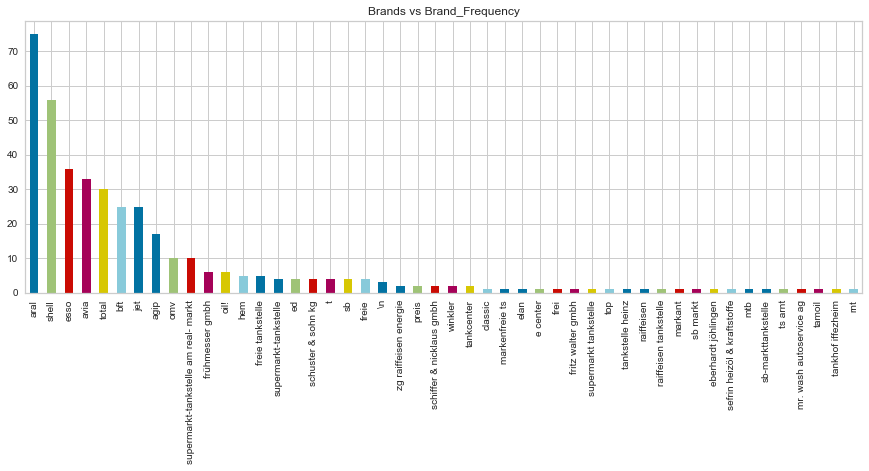

In [31]:
# Visualization of the different number of brands and their corresponding occurences in the dataset
dataset_small['BRAND'].value_counts().plot.bar(figsize = (15, 5), title = 'Brands vs Brand_Frequency')

#### Task 1.3 - Minimum and Maximum prices for Gasoline type per month

In [32]:
# Convert the type of the column to datetime
dataset_final['DATE_CHANGED'] = pd.to_datetime(dataset_final['DATE_CHANGED'])

In [33]:
# To get the latest date encountered in the dataset
dataset_final.DATE_CHANGED.max()

Timestamp('2015-09-29 23:34:01')

In [34]:
# To get the oldest date encountered in the dataset
dataset_final.DATE_CHANGED.min()

Timestamp('2014-06-08 09:50:01')

In [35]:
TS_Min = pd.to_datetime('07/06/2014')
TS_Max = pd.to_datetime('30/09/2015')

In [36]:
data_time = dataset_final.loc[(dataset_final.DATE_CHANGED >= TS_Min) & (dataset_final.DATE_CHANGED <= TS_Max), :]
data_time['YEAR'] = data_time.DATE_CHANGED.dt.year
data_time['MONTH'] = data_time.DATE_CHANGED.dt.month

/home/siddharth/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/siddharth/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
# To save the Minimum and Maximum prices of the different fuels wit respect to the months in a CSV File
date_time_Diesel_Max = data_time.groupby(['YEAR', 'MONTH'], sort = True)['DIESEL'].max()
date_time_Diesel_Max.to_csv('Diesel_Max.csv')
date_time_Diesel_Min = data_time.groupby(['YEAR', 'MONTH'], sort = True)['DIESEL'].min()
date_time_Diesel_Min.to_csv('Diesel_Min.csv')

date_time_E10_Max = data_time.groupby(['YEAR', 'MONTH'], sort = True)['E10'].max()
date_time_E10_Max.to_csv('E10_Max.csv')
date_time_E10_Min = data_time.groupby(['YEAR', 'MONTH'], sort = True)['E10'].min()
date_time_E10_Min.to_csv('E10_Min.csv')

date_time_E5_Max = data_time.groupby(['YEAR', 'MONTH'], sort = True)['E5'].max()
date_time_E5_Max.to_csv('E5_Max.csv')
date_time_E5_Min = data_time.groupby(['YEAR', 'MONTH'], sort = True)['DIESEL'].min()
date_time_E5_Min.to_csv('E5_Min.csv')


In [38]:
# Function to get the required fuel price relation with the month of the year in the required format. The input
# attribute to the function is the earlier saved CSV File
def get_max_or_min_data(csv_file):
    
    dataframe = pd.read_csv(csv_file, header = None)
    Year_Month = []
    for row in range(0, len(dataframe)):
        temp_x = str(dataframe.iloc[row, 1]) + str('-') + str(dataframe.iloc[row, 0])
        Year_Month.append(temp_x)
        temp = ''

    Fuel_Price = dataframe.iloc[:, 2].tolist()
    return(Fuel_Price, Year_Month)

In [39]:
Diesel_Max, Timeline = get_max_or_min_data('Diesel_Max.csv')
Diesel_Min, Timeline = get_max_or_min_data('Diesel_Min.csv')
E10_Max, Timeline = get_max_or_min_data('E10_Max.csv')
E10_Min, Timeline = get_max_or_min_data('E10_Min.csv')
E5_Max, Timeline = get_max_or_min_data('E5_Max.csv')
E5_Min, Timeline = get_max_or_min_data('E5_Min.csv')

In [40]:
# Converting the data received in a pandas Dataframe with a shared X - Axis i.e. Timeline
fuel_price = pd.DataFrame({'Timeline':Timeline})
fuel_price['Diesel_Max'] = np.array(Diesel_Max).reshape(len(Diesel_Max), 1)
fuel_price['Diesel_Min'] = np.array(Diesel_Min).reshape(len(Diesel_Min), 1)
fuel_price['E10_Max'] = np.array(E10_Max).reshape(len(E10_Max), 1)
fuel_price['E10_Min'] = np.array(E10_Min).reshape(len(E10_Min), 1)
fuel_price['E5_Max'] = np.array(E5_Max).reshape(len(E5_Max), 1)
fuel_price['E5_Min'] = np.array(E5_Min).reshape(len(E5_Min), 1)

[Text(0,0,'7-2014'),
 Text(0,0,'8-2014'),
 Text(0,0,'9-2014'),
 Text(0,0,'10-2014'),
 Text(0,0,'11-2014'),
 Text(0,0,'12-2014'),
 Text(0,0,'1-2015'),
 Text(0,0,'2-2015'),
 Text(0,0,'3-2015'),
 Text(0,0,'4-2015')]

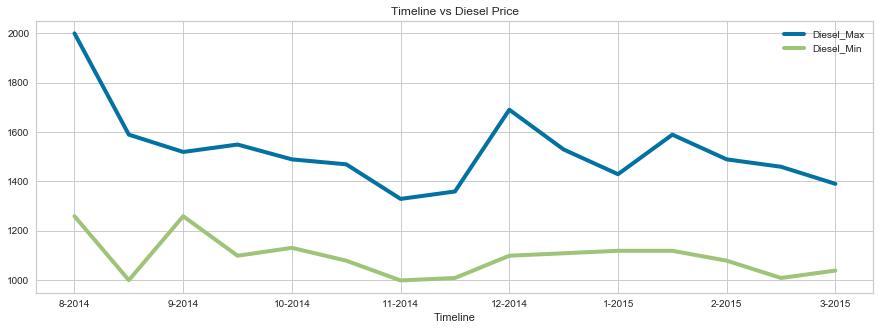

In [41]:
# Minimum and Maximum Diesel Prices for each month 
fuel_price.plot(x = "Timeline", y = ["Diesel_Max", "Diesel_Min"], figsize = (15, 5), linewidth = 4, title = 'Timeline vs Diesel Price', grid = True).set_xticklabels(fuel_price.Timeline)

[Text(0,0,'7-2014'),
 Text(0,0,'8-2014'),
 Text(0,0,'9-2014'),
 Text(0,0,'10-2014'),
 Text(0,0,'11-2014'),
 Text(0,0,'12-2014'),
 Text(0,0,'1-2015'),
 Text(0,0,'2-2015'),
 Text(0,0,'3-2015'),
 Text(0,0,'4-2015')]

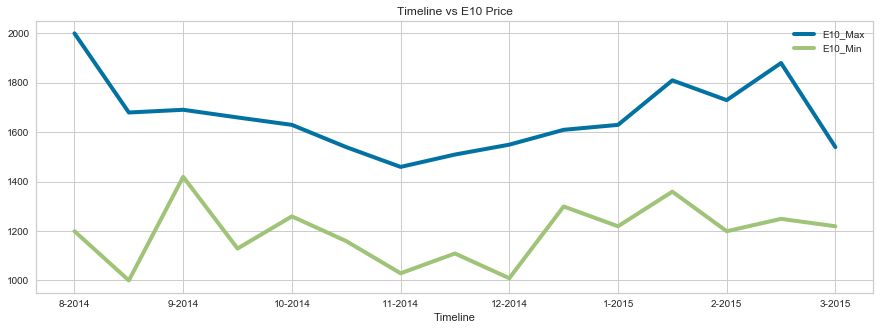

In [42]:
# Minimum and Maximum Diesel Prices for each month 
fuel_price.plot(x = "Timeline", y = ["E10_Max", "E10_Min"], figsize = (15, 5), linewidth = 4, title = 'Timeline vs E10 Price', grid = True).set_xticklabels(fuel_price.Timeline)

[Text(0,0,'7-2014'),
 Text(0,0,'8-2014'),
 Text(0,0,'9-2014'),
 Text(0,0,'10-2014'),
 Text(0,0,'11-2014'),
 Text(0,0,'12-2014'),
 Text(0,0,'1-2015'),
 Text(0,0,'2-2015'),
 Text(0,0,'3-2015'),
 Text(0,0,'4-2015')]

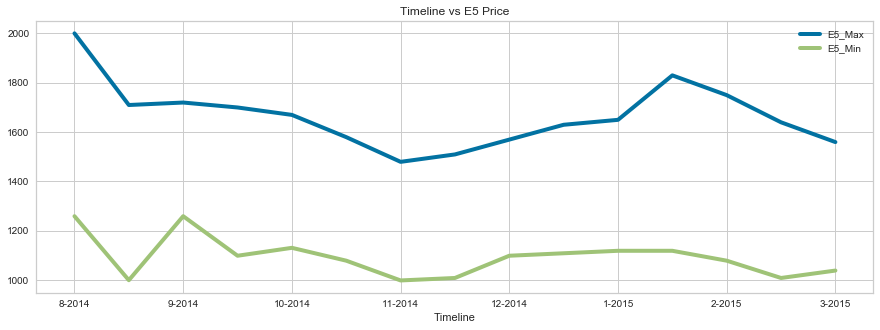

In [43]:
# Minimum and Maximum Diesel Prices for each month 
fuel_price.plot(x = "Timeline", y = ["E5_Max", "E5_Min"], figsize = (15, 5), linewidth = 4, title = 'Timeline vs E5 Price', grid = True).set_xticklabels(fuel_price.Timeline)

#### Task 1.4 - Additional Visual Plots

In [44]:
# The large car fleet company for logistic services has to bear in mind that only a few fuel stations operate on 
# on public holidays. It needs to strategize its transport in such a way during public holidays, that the truck can be refuelled.
# The plot below gives a basic idea of German states which have fuel stations operating on public holidays and their number 
# of occurences
holiday_dataset = (dataset_small['PUBLIC_HOLIDAY_IDENTIFIER'].value_counts())
holiday_dataset.drop(holiday_dataset.index[0], inplace = True)
holiday_dataset.plot.pie(title = 'Holiday_Locations vs Station_Open_Frequency_Percentage', autopct = '%.1f')
plt.text(1, 0.6, 'deRP-Rhineland Pfalz, deBY-Bayern, deBW-Baden Württemberg, deHE-Hessen', fontsize = 20)

Text(1,0.6,'deRP-Rhineland Pfalz, deBY-Bayern, deBW-Baden W\xc3\xbcrttemberg, deHE-Hessen')

Error in callback <function post_execute at 0x7f723aa941b8> (for post_execute):


ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

<Figure size 432x288 with 1 Axes>

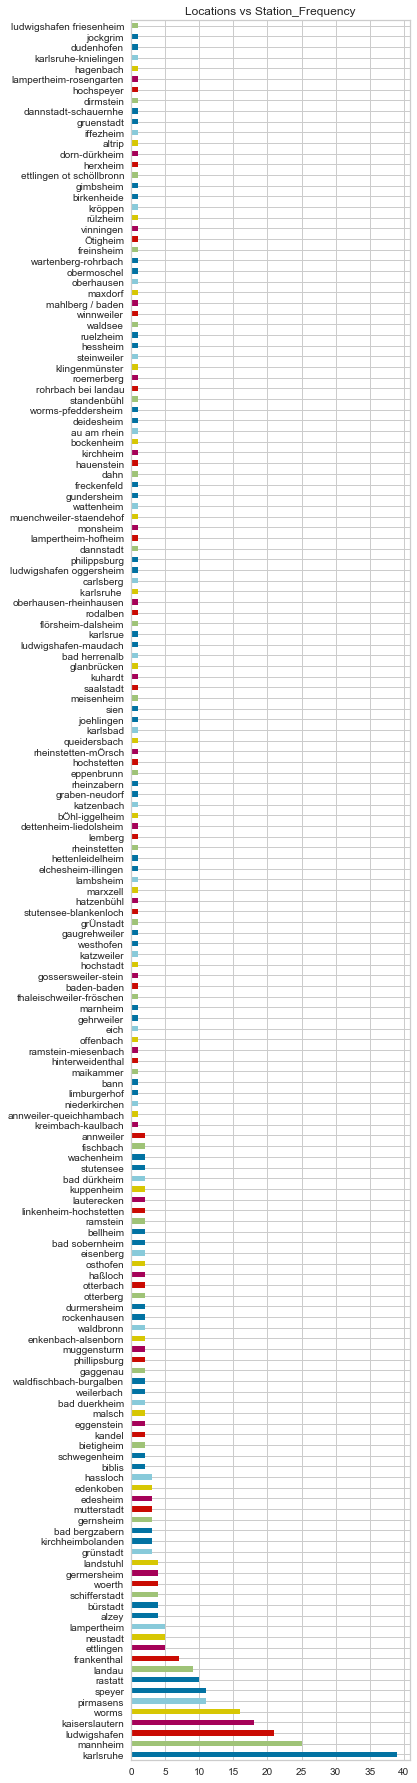

In [45]:
# The large car fleet company for logistic services has to bear in mind the cities and the number of fuel stations within 
# a city. It can strategize its fuelling dutring the transport in much efficient manner with this data
dataset_small['PLACE'].value_counts().plot.barh(figsize = (5, 32), title = 'Locations vs Station_Frequency')

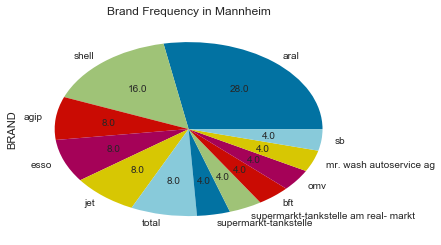

In [46]:
# The brand frequency within a particular city is of prime importance to the logistics company. If the company is for e.g 
#based in in Mannheim, it needs to know the dominant - brand within this city. The brand with more number of operating 
# stations within the city might be of particular benefits to the logistics company. For e.g. membership cards which 
# accumulate points after fuelling for the logistics company might result in huge long term benefits for the company.  
Mannheim_dataset = dataset_small.loc[dataset_small.PLACE == 'mannheim']
Mannheim_dataset = (Mannheim_dataset['BRAND'].value_counts())
Mannheim_dataset.plot.pie(title = 'Brand Frequency in Mannheim', autopct = '%.1f')

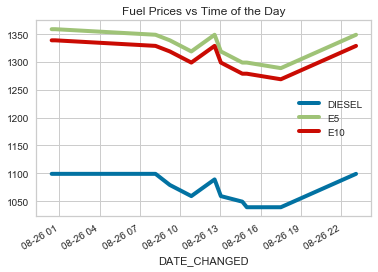

In [47]:
# The variation of fuel prices for a particular station within a city for different times of the day also might be 
# useful data for the logistics company. Accordingly it can strategize its fuelling time selection for the fleet for
# added cost benefits. For .e.g in the graph below, it can be seen that the fuel prices are relatively low in the 
# timeframe between 16:00 hours to 18:00 hours for all three types of fuel
fuel_price_per_day = pd.read_csv('Fuel_Prices_per_Day.csv')
fuel_price_per_day['DATE_CHANGED'] = pd.to_datetime(fuel_price_per_day['DATE_CHANGED'])
fuel_price_per_day.plot(x = 'DATE_CHANGED', y = ['DIESEL', 'E5', 'E10'] ,linewidth = 4, title = 'Fuel Prices vs Time of the Day', grid = True)

In [48]:
# The idea through this visualization is to optimize the fuelling strategy along the legendary 'Bertha Benz Memorial route'.
# The visualization provides a better understanding of the fuelling startegy. The pop - ups around the fuel station indicate 
# the price of the fuel and the red route is the route that is Bertha Benz route. Such visualizations can aid in a better
# selection of the fuelling strategy that can save costs for the fleet management company

coordinates = dataset_small.iloc[:, [5, 6]]

#Deutschland Coordinates
DE_COORDINATES = [49.353810,8.017510]

# Build map
MAP_DE = folium.Map(location=DE_COORDINATES, zoom_start = 8, tiles = 'cartodbpositron', width = 720, height = 500)
coordinates_LAT = coordinates['LAT'].tolist()
coordinates_LNG = coordinates['LNG'].tolist()
demo_prices = np.random.uniform(low=1000, high=2000, size=(412,1))

for (i,j,k) in zip(coordinates_LAT,coordinates_LNG,demo_prices):
    folium.CircleMarker(location = [i,j],popup = str(int(k)),radius = 5, fill = True).add_to(MAP_DE)

dataset_route = pd.read_csv('Benz_Route.csv')

route_coordinates = list(dataset_route.itertuples(index=False))
folium.PolyLine(route_coordinates, color="red").add_to(MAP_DE)
MAP_DE

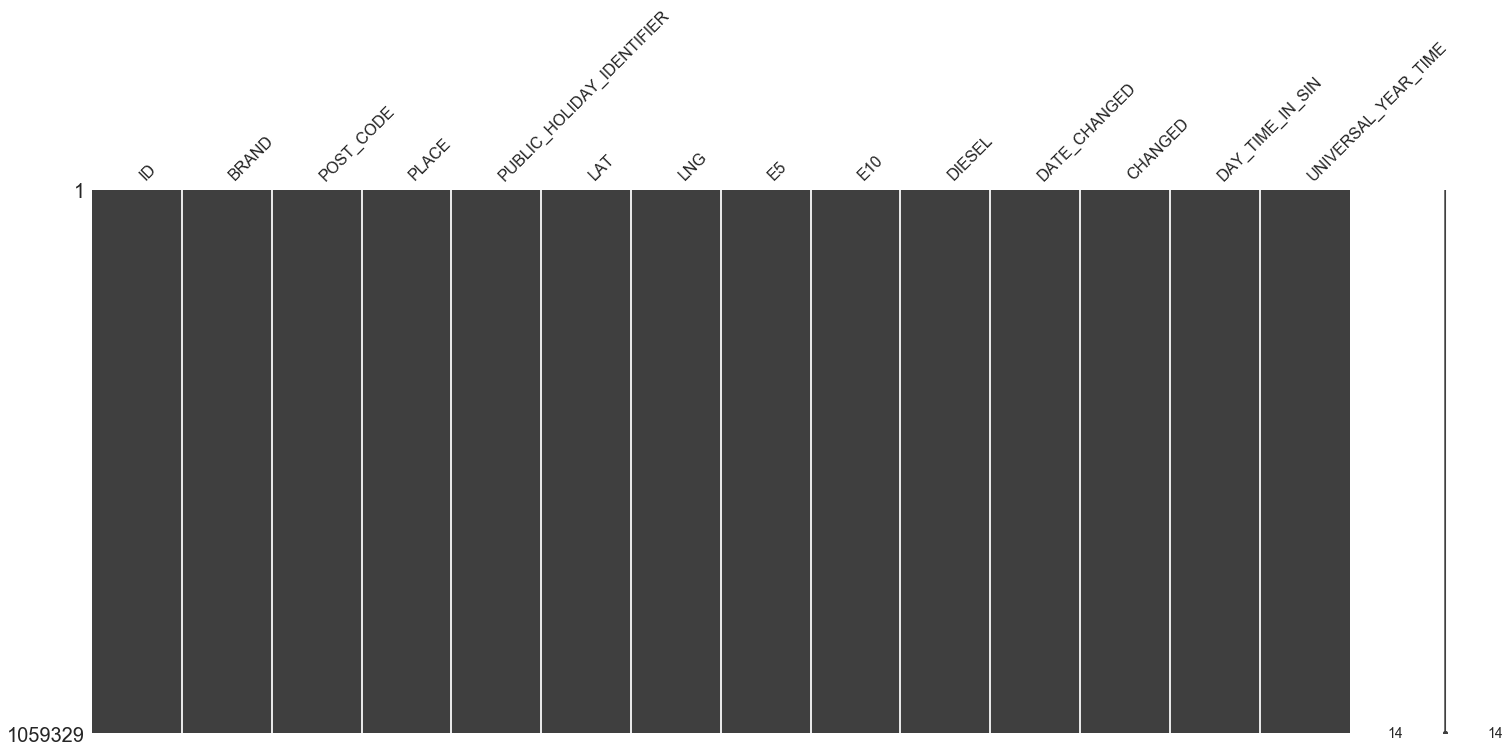

In [49]:
ms.matrix(dataset_final)

### Task 3 - Develop a Predictive Model

In [50]:
# Convert the type of the column to datetime
dataset_final['DATE_CHANGED'] = pd.to_datetime(dataset_final['DATE_CHANGED'])

In [51]:
# Creating a numpy array to encode the strings Place and Brand into a feature for the Model
Brand_for_Encoding = dataset_final.iloc[:, 1].values.copy()
Place_for_Encoding = dataset_final.iloc[:, 3].values.copy()

In [52]:
# Encoding the Brand and the Place
from sklearn.preprocessing import LabelEncoder
labelencoder_X_1 = LabelEncoder()
Brand_for_Encoding[:] = labelencoder_X_1.fit_transform(Brand_for_Encoding[:])

Place_for_Encoding[:] = labelencoder_X_1.fit_transform(Place_for_Encoding[:])

In [53]:
# Adding the encoded columns to the Dataframe
dataset_final['Encoded_Brand'] = Brand_for_Encoding
dataset_final['Encoded_Place'] = Place_for_Encoding

In [54]:
#Train Test split as per the Time Series - i.e. latest dates in the Test set
N = dataset_final.shape[0]
train_size = 0.8

datset_final = dataset_final.sort_values('DATE_CHANGED')
Train_Set = dataset_final.iloc[:int(N * train_size)]
Test_Set = dataset_final.iloc[int(N * train_size):]

In [55]:
# Using Features - Encoded Brand, Encoded Place, Latitude, Longitude, Day_Time_In_Sin and Universal Time
X_train = Train_Set.iloc[:, [14, 15, 5, 6, 12, 13]].values
X_test = Test_Set.iloc[:, [14, 15, 5, 6, 12, 13]].values

In [56]:
# Labels for the Fuel Prices - Diesel, E10, E5 (Train)
Y_train_DIESEL = Train_Set.iloc[:, 9].values
Y_train_E10 = Train_Set.iloc[:, 8].values
Y_train_E5 = Train_Set.iloc[:, 7].values

In [57]:
# Labels for the Fuel Prices - Diesel, E10, E5 (Test)
Y_test_DIESEL = Test_Set.iloc[:, 9].values
Y_test_E10 = Test_Set.iloc[:, 8].values
Y_test_E5 = Test_Set.iloc[:, 7].values

In [58]:
# Linear regression Model
from sklearn.linear_model import LinearRegression

# Build the Model.
logmodel = LinearRegression(normalize=False)

In [59]:
# Prediction for the fuel prices for Diesel, E10, E5 using Linear Regression 
logmodel.fit(X_train,Y_train_DIESEL)
Y_pred_DIESEL = logmodel.predict(X_test)
logmodel.fit(X_train, Y_train_E10)
Y_pred_E10 = logmodel.predict(X_test)
logmodel.fit(X_train, Y_train_E5)
Y_pred_E5 = logmodel.predict(X_test)

### Task 4 - Analyze the Result

DIESEL

In [60]:
# R2 Score for evaluation
from sklearn import metrics
print(metrics.r2_score(Y_test_DIESEL, Y_pred_DIESEL))

0.5233747523367588


In [61]:
# Mean Squared Error
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test_DIESEL, Y_pred_DIESEL)

4500.882093440572

In [62]:
# Explained variance score
from sklearn.metrics import explained_variance_score
explained_variance_score(Y_test_DIESEL, Y_pred_DIESEL)

0.5240587501738267

In [63]:
# Mean abolute Error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_test_DIESEL, Y_pred_DIESEL)

50.742786533432536

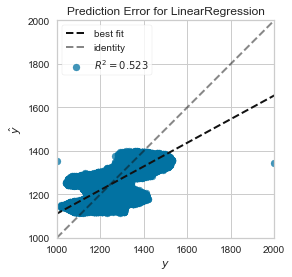

In [64]:
from yellowbrick.regressor import PredictionError
# Instantiate the linear model and visualizer
visualizer = PredictionError(logmodel)
visualizer.fit(X_train,Y_train_DIESEL)  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test_DIESEL)  # Evaluate the model on the test data
g = visualizer.poof()   

In [65]:
X_plot = list(range(0, len(Y_test_DIESEL)))

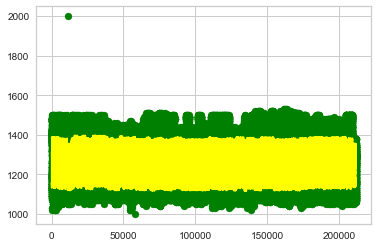

In [66]:
plt.scatter(X_plot, Y_test_DIESEL, color = 'green')
plt.plot(X_plot, Y_pred_DIESEL, color = 'yellow')

E10

In [67]:
# R2 Score for evaluation
print(metrics.r2_score(Y_test_E10, Y_pred_E10))

# Mean Squared Error
print(mean_squared_error(Y_test_E10, Y_pred_E10))

# Explained variance score
print(explained_variance_score(Y_test_E10, Y_pred_E10))

# Mean abolute Error
print(mean_absolute_error(Y_test_E10, Y_pred_E10))

0.14914788844334304
7677.634044358996
0.15085169287096378
69.62970187384735


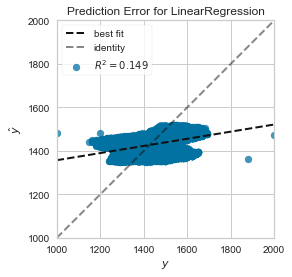

In [68]:
# Instantiate the linear model and visualizer
visualizer = PredictionError(logmodel)
visualizer.fit(X_train,Y_train_E10)  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test_E10)  # Evaluate the model on the test data
g = visualizer.poof()   

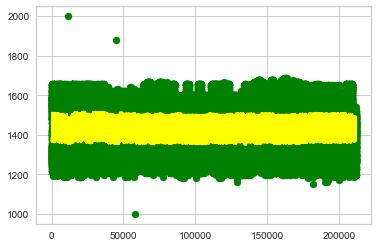

In [69]:
plt.scatter(X_plot, Y_test_E10, color = 'green')
plt.plot(X_plot, Y_pred_E10, color = 'yellow')

E5

In [70]:
# R2 Score for evaluation
print(metrics.r2_score(Y_test_E5, Y_pred_E5))

# Mean Squared Error
print(mean_squared_error(Y_test_E5, Y_pred_E5))

# Explained variance score
print(explained_variance_score(Y_test_E5, Y_pred_E5))

# Mean abolute Error
print(mean_absolute_error(Y_test_E5, Y_pred_E5))

0.20582417219024784
7829.573829144481
0.20734606401810263
70.0521058352934


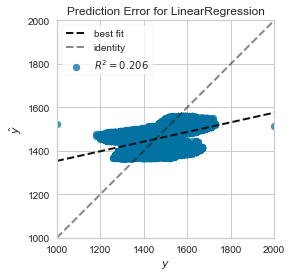

In [71]:
# Instantiate the linear model and visualizer
visualizer = PredictionError(logmodel)
visualizer.fit(X_train,Y_train_E5)  # Fit the training data to the visualizer
visualizer.score(X_test, Y_test_E5)  # Evaluate the model on the test data
g = visualizer.poof()  

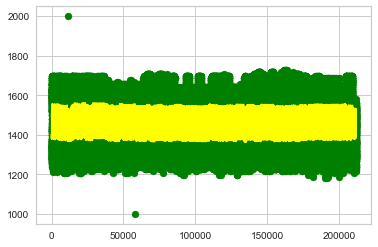

In [72]:
plt.scatter(X_plot, Y_test_E5, color = 'green')
plt.plot(X_plot, Y_pred_E5, color = 'yellow')

### Experimentation on Other Predictor Models (Only for Diesel)

In [73]:
# Bayesian ridge Model
from sklearn import linear_model
reg = linear_model.BayesianRidge()
reg.fit(X_train,Y_train_DIESEL)
Y_pred_DIESEL = reg.predict(X_test)
print(Y_pred_DIESEL - Y_test_DIESEL)

[119.92620552 128.08736497  83.86189496 ...  82.12831599  93.25706901
  67.86922915]


In [74]:
# SGD Regressor Model
clf = linear_model.SGDRegressor()
clf.fit(X_train,Y_train_DIESEL)
Y_pred_DIESEL = clf.predict(X_test)
print(Y_pred_DIESEL - Y_test_DIESEL)

/home/siddharth/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[-2.37308634e+26 -2.37308634e+26 -2.37322866e+26 ... -2.35131681e+26
 -2.35173785e+26 -2.35188017e+26]


In [75]:
# Passive Agressive Regressor Model
regr = linear_model.PassiveAggressiveRegressor(random_state=0)
regr.fit(X_train,Y_train_DIESEL)
Y_pred_DIESEL = regr.predict(X_test)
print(Y_pred_DIESEL - Y_test_DIESEL)

/home/siddharth/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[407.6438914  417.6438914  367.73005255 ... 274.46482497 274.71971838
 254.80587954]


In [76]:
# LARS Lasso Model
lass = linear_model.LassoLars(alpha = 0.1)
lass.fit(X_train,Y_train_DIESEL)
Y_pred_DIESEL = lass.predict(X_test)
print(Y_pred_DIESEL - Y_test_DIESEL)

[219.07391827 229.07391827 179.07391827 ...  99.07391827  99.07391827
  79.07391827]


In [77]:
# Polynomial Regresssion Model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create a Linear Regressor   
lin_regressor = LinearRegression()

# Pass the order of your polynomial here  
poly = PolynomialFeatures(2)

# Convert to be used further to linear regression
X_transform = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

# Fit this to Linear Regressor
lin_regressor.fit(X_transform,Y_train_DIESEL) 

# Get the predictions
Y_pred_DIESEL = lin_regressor.predict(X_test)
print(Y_pred_DIESEL - Y_test_DIESEL)

[141.1428347  149.1150427  105.92994663 ...  66.60712011  81.07008083
  54.60431011]


### End of File
### Thank You !